# Setup & Config

In [1]:
!rm -r /kaggle/working/*
%cd /kaggle/working

/kaggle/working


## Kaggle Environment

In [2]:
import os
from tqdm import tqdm

KAGGLE_ENV = not os.path.exists("/kaggle/.vscode")
ENV_NAME = "kaggle" if KAGGLE_ENV else "local"
print(f"{KAGGLE_ENV=}")
print(f"{ENV_NAME=}")

if KAGGLE_ENV:
    !pip install -U -q plyvel --no-index --find-links=file:///kaggle/input/uspto-gen-wheel/plyvel

    move_dirs = (
        [
        "/kaggle/input/uspto-patent2cpc-dataset",
        ] 
        + [f"/kaggle/input/uspto-tokenized-db-dataset-{i}/tokenized-db-{i}" for i in range(10)]
    )

    !mkdir /kaggle/tmp
    for move_dir in tqdm(move_dirs):
        !cp -r {move_dir} /kaggle/tmp/{move_dir.split("/")[-1]}
    !ls /kaggle/tmp

KAGGLE_ENV=False
ENV_NAME='local'


## Load Library

In [3]:
import os
import sys

if KAGGLE_ENV:
    PACKAGE_DIR = "/kaggle/input/uspto-src/src"
else:
    PACKAGE_DIR = "/kaggle/src"
sys.path.append(PACKAGE_DIR)
sys.path.append(os.path.join(PACKAGE_DIR, "Penguin-ML-Library"))

In [4]:
import json
import multiprocessing
import random
import warnings
from collections import Counter
from typing import List, Set, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import plyvel
import polars as pl
import yaml
from penguinml.utils.logger import get_logger, init_logger
from penguinml.utils.set_seed import seed_base
from penguinml.utils.timer import Timer
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

import whoosh_utils
from const import INF, KEY2QUERY, NUM_CPU, QUERY2KEY
from db import CompleteDB, SingleTokenDB, TokinezedDB
from solver import HitBlock, SimulatedAnnealing, State
from utils import compute_ap, evaluate, load_list_bz2

warnings.filterwarnings("ignore")
MODEL_NAME = "baseline"
CFG = yaml.safe_load(open(os.path.join(PACKAGE_DIR, "config.yaml"), "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])
CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
# !rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

init_logger("log.log")
logger = get_logger("main")
seed_base(CFG[MODEL_NAME]["execution"]["seed"])

2024-07-27 16:27:19.301415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 16:27:19.638017: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 16:27:20.509380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

Processing /kaggle/input/whoosh-wheel-2-7-4/Whoosh-2.7.4-py2.py3-none-any.whl
Whoosh is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


set seed: 46


exp_0001


## Dataset Preparation

In [5]:
if KAGGLE_ENV:
    #     TRAIN_PATH = "/kaggle/input/uspto-train-index-2500/train2500_seed0.parquet"
    TRAIN_PATH = "/kaggle/input/uspto-explainable-ai/test.csv"
    TRAIN_INDEX_PATH = "/kaggle/input/uspto-train-index-2500/index_2500_200k"

    # database
    PATENT2RARE_TOKENS_PATH = "/kaggle/tmp/uspto-rare-tokens-dataset/db"

    PATENT2CPC_PATH = "/kaggle/tmp/uspto-patent2cpc-dataset/db"

    TOKENIZED_SPLIT = 10
    TOKENIZED_DB_PATHES = [f"/kaggle/tmp/tokenized-db-{i}/db" for i in range(TOKENIZED_SPLIT)]
    TOKENIZED_INDEX_PATHES = [
        f"/kaggle/input/uspto-tokenized-index-{i}/index.lz4" for i in range(TOKENIZED_SPLIT)
    ]

    TRAIN_MODE = "train" in TRAIN_PATH
else:
    TRAIN_PATH = "/kaggle/input/uspto-train-data-2500/train2500_seed0.parquet"
    # TRAIN_INDEX_PATH = "/kaggle/input/train-index-2500/index_2500_200k"
    TRAIN_INDEX_PATH = "/kaggle/input/train-index-difficult/index_2500_1M"

    # database
    PATENT2RARE_TOKENS_PATH = "/kaggle/input/rare-tokens/db"

    PATENT2CPC_PATH = "/kaggle/input/patent2cpc/db"

    TOKENIZED_SPLIT = 10
    TOKENIZED_DB_PATHES = [
        f"/kaggle/input/all-index-per-patent/split/tokenized-db-{i}/db"
        for i in range(TOKENIZED_SPLIT)
    ]
    TOKENIZED_INDEX_PATHES = [
        f"/kaggle/input/all-index-per-patent/split/tokenized-db-{i}/index.lz4"
        for i in range(TOKENIZED_SPLIT)
    ]

    DANGER_PATENTS_PATH = "/kaggle/input/similar-patents/danger_patents_0.9.json"

    TRAIN_MODE = True

In [6]:
if TRAIN_PATH.split(".")[-1] == "parquet":
    train = pl.read_parquet(TRAIN_PATH)
else:
    train = pl.read_csv(TRAIN_PATH)

if TRAIN_MODE:
    train = train.filter(~train["publication_number"].str.starts_with("US-D"))

all_patents = set()
for i in range(50):
    all_patents.update(train[f"target_{i}"].to_list())
all_patents.update(train["publication_number"].to_list())
print(len(all_patents))

if TRAIN_MODE:
    train = train.head(300)
train.head(1)

116164


publication_number,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,target_36,target_37,target_38,target_39,target_40,target_41,target_42,target_43,target_44,target_45,target_46,target_47,target_48,target_49
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""US-2011086809-…","""US-2006229256-…","""US-2009192226-…","""US-2023114071-…","""US-7754692-B2""","""US-9345727-B2""","""US-7829126-B2""","""US-2012171231-…","""US-2012171164-…","""US-2023140478-…","""US-2021138042-…","""US-9226914-B2""","""US-11389403-B2…","""US-2016029681-…","""US-10342244-B2…","""US-2021145782-…","""US-2007166411-…","""US-7867541-B2""","""US-10028519-B2…","""US-9386794-B2""","""US-2012171328-…","""US-2013338228-…","""US-2023102803-…","""US-10688070-B2…","""US-2014308393-…","""US-2016106799-…","""US-9370553-B2""","""US-2014303067-…","""US-9474766-B2""","""US-2015157048-…","""US-2018310605-…","""US-2023149542-…","""US-2017105445-…","""US-2011208153-…","""US-9345741-B2""","""US-2022386675-…","""US-2006229366-…","""US-9241923-B2""","""US-11606966-B2…","""US-2007202052-…","""US-2012171163-…","""US-2013230503-…","""US-2015305359-…","""US-2010179104-…","""US-2016015068-…","""US-2022233488-…","""US-2020230162-…","""US-2022168399-…","""US-9107894-B2""","""US-2023013644-…","""US-2014328970-…"


In [7]:
if TRAIN_MODE:
    train_idx = whoosh_utils.load_index(TRAIN_INDEX_PATH)
    searcher = whoosh_utils.get_searcher(train_idx)
    qp = whoosh_utils.get_query_parser()

In [8]:
patent2rare_tokens = plyvel.DB(PATENT2RARE_TOKENS_PATH, create_if_missing=False)
patent2cpc = plyvel.DB(PATENT2CPC_PATH, create_if_missing=False)
tokenized_db = TokinezedDB(TOKENIZED_DB_PATHES, TOKENIZED_INDEX_PATHES)

In [9]:
def load_patent_tokens(target: str):
    data = tokenized_db.get(target)
    if data is None:
        return None
    return data

In [10]:
if KAGGLE_ENV:
    with open("/kaggle/input/uspto-json/token_counts.json", "r") as f:
        token_counts = json.load(f)
    with open("/kaggle/input/uspto-json/cpc2count.json", "r") as f:
        cpc2count = json.load(f)
else:
    with open("/kaggle/input/token-counts/token_counts.json", "r") as f:
        token_counts = json.load(f)
    with open("/kaggle/input/cpc-counts/cpc2count.json", "r") as f:
        cpc2count = json.load(f)

---
# Main Part

In [11]:
MAX_TOKEN = 25
MAX_SCORE = 350


def process(target_ids) -> str:
    target_ids = target_ids[1:]
    assert len(target_ids) == 50

    patent2tokens = {}
    for target in target_ids:
        data = load_patent_tokens(target)
        if data is None:
            patent2tokens[target] = {}
        else:
            patent2tokens[target] = data

        cpcs = json.loads(patent2cpc.get(target.encode()).decode())
        patent2tokens[target]["cpc"] = cpcs

    query_mat = [[None for _ in range(50)] for _ in range(50)]
    score_mat = np.full((50, 50), MAX_SCORE)
    rare_mat = [[None for _ in range(50)] for _ in range(50)]
    for i in range(50):
        for j in range(i + 1, 50):
            target1 = target_ids[i]
            target2 = target_ids[j]
            common_tokens = []
            for key in patent2tokens[target1].keys():
                if key not in patent2tokens[target2]:
                    continue
                tokens1 = set(patent2tokens[target1][key])
                tokens2 = set(patent2tokens[target2][key])
                common = list(tokens1 & tokens2)
                if key == "cpc":
                    common = [f"cpc:{token}" for token in common]
                else:
                    common = [f"{KEY2QUERY[key]}:{token}" for token in common]
                common_tokens += common

            rare_tokens = []
            for token in common_tokens:
                _key, _token = token.split(":")
                if _key == "cpc":
                    count = cpc2count.get(_token, 14_000_000)
                else:
                    count = token_counts[QUERY2KEY[_key]].get(_token, 14_000_000)
                rare_tokens.append((count, _key, _token))
            rare_tokens = sorted(rare_tokens)
            rare_mat[i][j] = rare_tokens
            rare_mat[j][i] = rare_tokens

            this_query = ""
            for _, key, token in rare_tokens[:MAX_TOKEN]:
                this_token = f'{key}:"{token}"'
                if len(this_query) + len(this_token) >= 390:
                    break
                this_query += this_token
            query_mat[i][j] = f"({this_query})"
            query_mat[j][i] = f"({this_query})"

            score = 0
            for t in range(MAX_TOKEN):
                if len(rare_tokens) <= t:
                    count = 14_000_000
                else:
                    count, _, _ = rare_tokens[t]
                score += np.log(count)
            score_mat[i, j] = score
            score_mat[j, i] = score

            if len(this_query) >= 390 or score > MAX_SCORE:
                query_mat[i][j] = None
                query_mat[j][i] = None
                score_mat[i, j] = MAX_SCORE
                score_mat[j, i] = MAX_SCORE

    # マッチング
    G = nx.Graph()
    for i in range(50):
        for j in range(i + 1, 50):
            G.add_edge(i, j, weight=score_mat[i, j])
    matching = nx.algorithms.matching.min_weight_matching(G)

    used = set()
    this_queries = []
    scores = []
    pairs = []
    for i, j in list(matching):
        if i in used or j in used:
            continue
        if query_mat[i][j] is None:
            continue
        results = whoosh_utils.execute_query(query_mat[i][j], qp, searcher)
        results = set(results) & all_patents
        if len(results) > 2:
            continue

        scores.append(score_mat[i, j])
        this_queries.append(query_mat[i][j])
        used.add(i)
        used.add(j)
        pairs.append((i, j))

    single_queries = []
    while len(single_queries) + len(this_queries) < 25 and len(used) < 50:
        i = random.choice(list(set(range(50)) - used))
        used.add(i)

        data = patent2rare_tokens.get(target_ids[i].encode())
        if data is None:
            continue
        rare_tokens = json.loads(data.decode())
        if rare_tokens is None or len(rare_tokens) == 0:
            continue

        tokens = ""
        for _, token in rare_tokens[:MAX_TOKEN]:
            key, token = token.split(":")
            this = f'{key}:"{token}"'
            if len(this) + len(tokens) >= 380:
                break
            tokens += this
        this_query = f"({tokens})"
        single_queries.append(this_query)

    can_use_len = 390 * 25 - sum([len(q) for q in single_queries])
    this_queries = ["" for _ in range(len(this_queries))]
    cur_sum = 0
    fail_count = 0
    for i in range(1000000):
        pair_i, cycle = i % len(this_queries), i // len(this_queries)
        if cycle >= len(rare_mat[pairs[pair_i][0]][pairs[pair_i][1]]):
            fail_count += 1
            if fail_count > 25:
                break
            continue
        count, key, token = rare_mat[pairs[pair_i][0]][pairs[pair_i][1]][cycle]
        if cycle >= MAX_TOKEN and count > 14_000_000 * 0.05:
            fail_count += 1
            continue
        this_token = f'{key}:"{token}"'
        if cur_sum + len(this_token) > can_use_len:
            fail_count += 1
            if fail_count > 25:
                break
            continue
        cur_sum += len(this_token)
        this_queries[pair_i] += this_token
        fail_count = 0
    for i in range(len(this_queries)):
        this_queries[i] = f"({this_queries[i]})"
    this_queries += single_queries

    query = " OR ".join(this_queries)
    if len(query) == 0:
        query = "hogefugafooooo"
    # print(f"mean={np.mean(scores)}, min={np.min(scores)}, max={np.max(scores)}")
    return query


with multiprocessing.Pool(NUM_CPU) as pool:
    queries = list(tqdm(pool.imap(process, train.iter_rows()), total=len(train)))

100%|██████████| 300/300 [01:44<00:00,  2.88it/s]


== Evaluation ==


100%|██████████| 300/300 [01:02<00:00,  4.77it/s]


mAP: 0.9948  mHit: 49.24


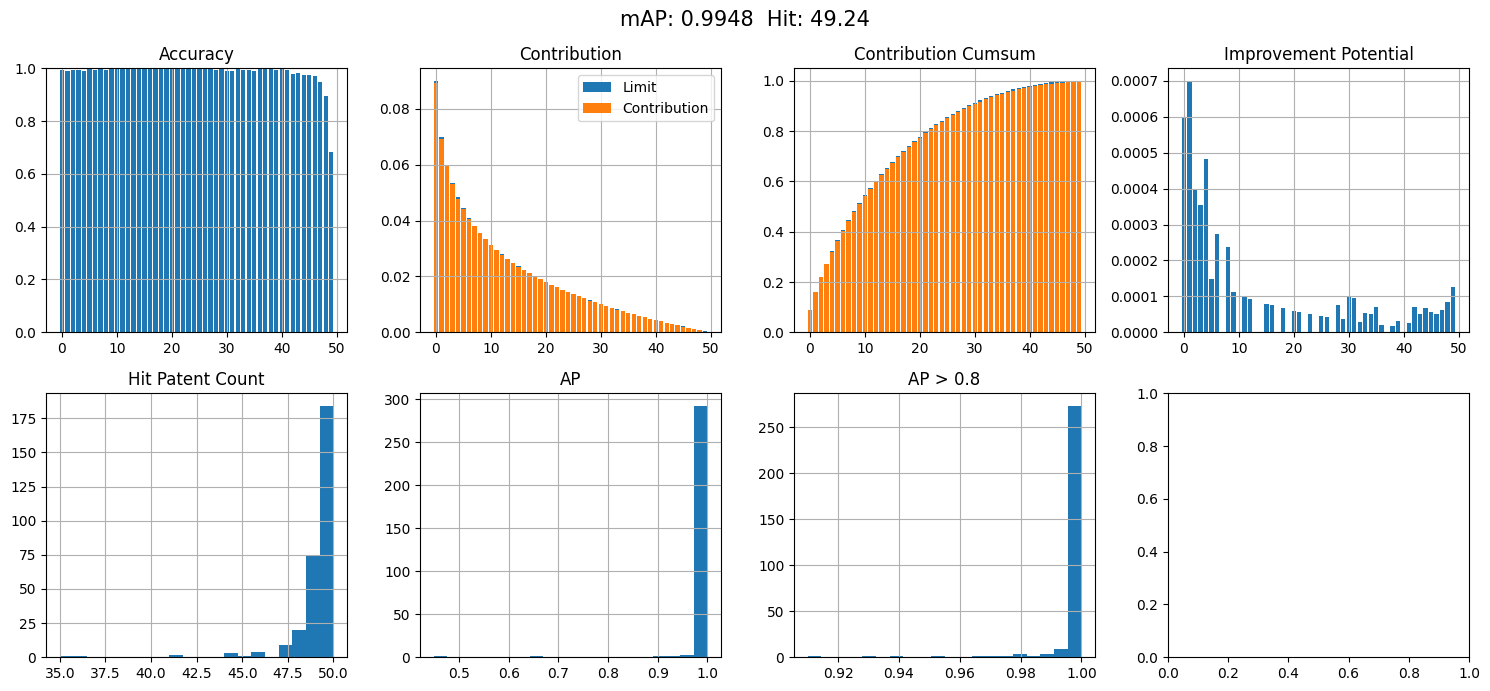

In [12]:
# 評価
def process(x):
    return whoosh_utils.execute_query(x, qp, searcher)


if TRAIN_MODE:
    print("== Evaluation ==")
    with multiprocessing.Pool(NUM_CPU) as pool:
        all_results = list(tqdm(pool.imap(process, queries), total=len(queries)))
    aps = evaluate(all_results, list(train.iter_rows()))

In [13]:
# submit
train = train.with_columns(pl.Series("query", queries)).select(["publication_number", "query"])
train.write_csv("submission.csv")
train.head(1)

publication_number,query
str,str
"""US-2011086809-…","""(ab:""preterm""d…"


(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0., 298.]),
 array([8796., 8906., 9016., 9126., 9236., 9346., 9456., 9566., 9676.,
        9786., 9896.]),
 <BarContainer object of 10 artists>)

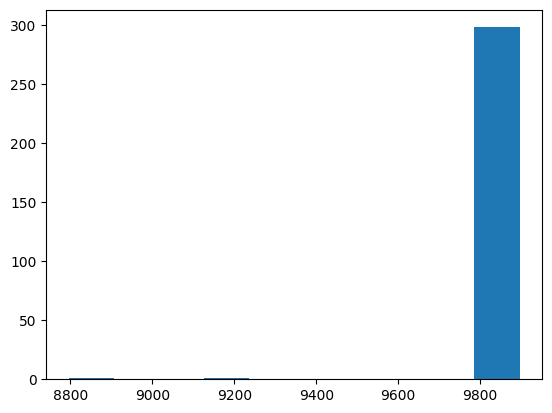

In [14]:
lens = []
for query in queries:
    lens.append(len(query))
plt.hist(lens)